### **Step 1: Setting Up the Environment and Loading Artifacts**

Before we begin, we will import the necessary libraries and load the configuration files (`config.json`) and tools (`preprocessor`, `kmeans`) that we saved from the previous segmentation project. This step ensures that this notebook is built upon the knowledge and logic of the first project.

In [1]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, warnings, sklearn, sys
from pathlib import Path
from joblib import load

# --- Scikit-learn Modules ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# --- Notebook Settings ---
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# === 1) LOADING ARTIFACTS ===
print("Loading artifacts from the segmentation project...")
art_dir = Path("artifacts")
cfg_path = art_dir / "config.json"
preproc_path = art_dir / "preprocessor_kmeans.joblib"
kmeans_path  = art_dir / "kmeans_k3.joblib"

if not cfg_path.exists():
    raise RuntimeError("`artifacts/config.json` not found. Please run the Export cell in the segmentation notebook first.")

with cfg_path.open("r", encoding="utf-8") as f:
    CFG = json.load(f)

# We load these for consistency (good for version/schema checks even if not used directly)
preproc_kmeans = load(preproc_path) if preproc_path.exists() else None
kmeans_k3      = load(kmeans_path)  if kmeans_path.exists()  else None
print("Artifacts loaded successfully.")

# Version warning (for informational purposes)
cfg_skl = CFG.get("versions", {}).get("sklearn")
if cfg_skl and cfg_skl.split(".")[:2] != sklearn.__version__.split(".")[:2]:
    warnings.warn(f"Warning: sklearn version mismatch. Trained with: {cfg_skl} | Current: {sklearn.__version__}. "
                  "Minor version differences are usually fine, but pipeline behavior could change.")

# === 2) CONFIGURATION AND HELPER FUNCTION ===
W_LOW   = CFG["winsor_low_bounds"]
W_HIGH  = CFG["winsor_high_bounds"]
WIN_COLS = CFG["winsor_cols"]
MODEL_INPUT_COLS = CFG["model_input_cols"]
CATEGORICAL_FEATURES = CFG.get("categorical_features", [])
NUMERIC_FEATURES     = CFG.get("numeric_features", [])
TARGET_COL = "TARGET"

# Safety check: do the main keys exist?
assert isinstance(WIN_COLS, list) and isinstance(MODEL_INPUT_COLS, list), "config.json is missing expected keys."

def apply_winsor(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies winsorization using the same lower/upper bounds calculated in the segmentation notebook.
    Object-type columns are converted to numeric; invalid values become NaN.
    """
    df = df.copy()
    for c in WIN_COLS:
        if c in df.columns:
            lo, hi = W_LOW.get(c), W_HIGH.get(c)
            if lo is not None and hi is not None:
                df[c] = pd.to_numeric(df[c], errors="coerce").clip(lower=lo, upper=hi)
    return df

print("\nEnvironment and helper functions are ready.")

Loading artifacts from the segmentation project...
Artifacts loaded successfully.

Environment and helper functions are ready.


### **Step 2: Loading and Consistently Preparing the Data**

In this critical step, we will load the raw `application_train.csv` data and prepare it for training our Logistic Regression model. The primary goal of this process is to ensure **100% consistency** with the previous segmentation project. This guarantees that both models operate on the same core assumptions and data structure, allowing them to be harmoniously integrated into the future Streamlit application.

The operations in this cell are as follows:
1.  **Efficient Loading:** Only the columns necessary for modeling will be loaded into memory using the `usecols` parameter.
2.  **Anomaly Correction:** The nonsensical values in the `DAYS_EMPLOYED` column will be corrected to `NaN`, just as in the segmentation project.
3.  **Feature Engineering:** New features (`AGE_YEARS`, `CREDIT_TO_INCOME_RATIO`, etc.) will be derived using the **exact same** formulas and `safe_div` function defined and used in the segmentation project.
4.  **Schema Consistency:** By using the `MODEL_INPUT_COLS` list loaded from `config.json`, we will ensure that the model's input DataFrame matches the first project in terms of both column names and **order**.
5.  **Outlier Management:** Outliers will be suppressed by calling the `apply_winsor` helper function with the **exact same lower and upper bounds** calculated in the first project.
6.  **Data Type Adjustment:** The data type of categorical columns will be set to `category` to ensure they are correctly identified by the `preprocessor`.

At the end of these steps, we will have a completely clean, consistent, and ready `X_lr` (features) and `y_lr` (target) dataset to train our Logistic Regression model.

In [2]:
# === Step 2: Load Data + Prepare Features (LR-compatible) ===
from IPython.display import display
import pandas as pd
import numpy as np

RAW_PATH = "data/application_train.csv"

# 1) Read the dataset (only required columns)
base_cols = [
    'TARGET','CODE_GENDER','CNT_CHILDREN','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE',
    'DAYS_BIRTH','AMT_INCOME_TOTAL','NAME_INCOME_TYPE','DAYS_EMPLOYED',
    'NAME_CONTRACT_TYPE','AMT_CREDIT','AMT_ANNUITY','EXT_SOURCE_2','EXT_SOURCE_3'
]
# A small trick to ensure EXT_SOURCE_3 is the last column if it exists, for consistency
df_raw = pd.read_csv(RAW_PATH, usecols=[c for c in base_cols if c != 'EXT_SOURCE_3'] + ['EXT_SOURCE_3'])
print(f"Loaded: {df_raw.shape}")

# 2) Anomaly correction: DAYS_EMPLOYED = 365243 -> NaN
df_raw['DAYS_EMPLOYED'] = df_raw['DAYS_EMPLOYED'].replace({365243: np.nan})

# 3) Feature engineering (identical to segmentation)
def safe_div(num, den):
    num = pd.to_numeric(num, errors='coerce')
    den = pd.to_numeric(den, errors='coerce')
    out = np.where((den > 0) & np.isfinite(den) & np.isfinite(num), num / den, np.nan)
    return pd.Series(out, index=num.index)

df_feat = df_raw.copy()
df_feat['AGE_YEARS']            = (-df_feat['DAYS_BIRTH'] / 365)
df_feat['YEARS_EMPLOYED']       = (-df_feat['DAYS_EMPLOYED'] / 365)
df_feat['CREDIT_TO_INCOME_RATIO']  = safe_div(df_feat['AMT_CREDIT'],  df_feat['AMT_INCOME_TOTAL'])
df_feat['ANNUITY_TO_INCOME_RATIO'] = safe_div(df_feat['AMT_ANNUITY'], df_feat['AMT_INCOME_TOTAL'])
df_feat['EMPLOYED_TO_AGE_RATIO']   = safe_div(df_feat['YEARS_EMPLOYED'], df_feat['AGE_YEARS'])
df_feat['CREDIT_TERM']             = safe_div(df_feat['AMT_CREDIT'],  df_feat['AMT_ANNUITY'])  # ≈ term in years

# 4) Create LR input table: Generate the MODEL_INPUT_COLS schema
# (Came from the segmentation export — order & names will be identical)
missing_in_feat = [c for c in MODEL_INPUT_COLS if c not in df_feat.columns]
assert not missing_in_feat, f"Missing feature(s): {missing_in_feat}"

X_lr = df_feat[MODEL_INPUT_COLS].copy()   # only model inputs
y_lr = df_feat[TARGET_COL].astype(int)    # target

# 5) Winsorization (using the same boundaries)
X_lr = apply_winsor(X_lr)

# 6) Data type setup (categorical/numerical)
cat_cols = CFG.get("categorical_features", [])
num_cols = CFG.get("numeric_features", [])
for c in cat_cols:
    if c in X_lr.columns:
        X_lr[c] = X_lr[c].astype('category')

print("Ready:")
print(f"X_lr shape: {X_lr.shape} | y_lr shape: {y_lr.shape}")
print("Sample rows:")
display(X_lr.head())

Loaded: (307511, 14)
Ready:
X_lr shape: (307511, 17) | y_lr shape: (307511,)
Sample rows:


,CODE_GENDER,CNT_CHILDREN,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY,EXT_SOURCE_2,EXT_SOURCE_3,AGE_YEARS,YEARS_EMPLOYED,CREDIT_TO_INCOME_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_AGE_RATIO,CREDIT_TERM
0,M,0,Single / not married,Secondary / secondary special,"202,500.000",Working,Cash loans,"406,597.500","24,700.500",0.263,0.139,25.921,1.745,2.008,0.122,0.067,16.461
1,F,0,Married,Higher education,"270,000.000",State servant,Cash loans,"1,293,502.500","35,698.500",0.622,NaN,45.932,3.255,4.791,0.132,0.071,36.234
2,M,0,Single / not married,Secondary / secondary special,"67,500.000",Working,Revolving loans,"135,000.000","6,750.000",0.556,0.730,52.181,0.616,2.000,0.100,0.012,20.000
3,F,0,Civil marriage,Secondary / secondary special,"135,000.000",Working,Cash loans,"312,682.500","29,686.500",0.650,NaN,52.068,8.326,2.316,0.220,0.160,10.533
4,M,0,Single / not married,Secondary / secondary special,"121,500.000",Working,Cash loans,"513,000.000","21,865.500",0.323,NaN,54.608,8.323,4.222,0.180,0.152,23.462


### **Step 3: Creating Training and Test Sets**

To objectively measure our model's performance, we need to split our dataset into two parts: a **training set**, which the model will learn from, and a **test set**, on which we will test its performance on data it has never seen before.

In this imbalanced dataset, it is crucial to ensure that the `TARGET` variable (the default rate) is distributed proportionally in both sets. Therefore, we will perform the split using the `stratify` parameter.

In [3]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% test
# stratify=y_lr -> Ensures that the default rate in both the train and test sets
# is the same as in the original dataset.
X_train, X_test, y_train, y_test = train_test_split(
    X_lr, y_lr, 
    test_size=0.20, 
    random_state=RANDOM_STATE, 
    stratify=y_lr
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape:   {X_test.shape}\n")
print(f"Original data default rate: {y_lr.mean():.3f}")
print(f"Training set default rate:  {y_train.mean():.3f}")
print(f"Test set default rate:    {y_test.mean():.3f}")

Training set shape: (246008, 17)
Test set shape:   (61503, 17)

Original data default rate: 0.081
Training set default rate:  0.081
Test set default rate:    0.081


### **Step 4: Building the Preprocessing and Model Pipeline for Logistic Regression**

Before training our Logistic Regression model, we will combine all the preprocessing steps and the model itself into a single `Pipeline` object. This approach prevents data leakage, keeps the code organized, and makes it easy to apply the model to new data later on.

Our pipeline will include the following steps:
1.  **Preprocessor:** A `ColumnTransformer` that will handle missing data imputation, scaling, and encoding separately for numerical and categorical columns.
2.  **Model:** A `LogisticRegression` model configured with the `class_weight='balanced'` parameter to manage the class imbalance.

In [4]:
# Required libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# If the feature lists from config.json are empty, let's derive them automatically from X_lr.
if not CATEGORICAL_FEATURES or not NUMERIC_FEATURES:
    print("Warning: Feature lists from config.json are empty, deriving them automatically.")
    CATEGORICAL_FEATURES = X_lr.select_dtypes(include=['object','category']).columns.tolist()
    NUMERIC_FEATURES     = X_lr.select_dtypes(include=np.number).columns.tolist()

# 1) Define the preprocessing steps for LR
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# Create a OneHotEncoder that works with both old and new versions of scikit-learn.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", ohe) # We use the version-compatible ohe object here
])

# Combine these steps with ColumnTransformer
preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, NUMERIC_FEATURES),
        ("cat", categorical_tf, CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# 2) Define the Logistic Regression model
logreg = LogisticRegression(
    solver="liblinear",
    class_weight="balanced", # The most important parameter for imbalanced classes
    max_iter=1000,
    random_state=RANDOM_STATE
)

# 3) Combine all steps into a single final Pipeline
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_lr),
    ("model", logreg)
])

print("\nLogistic Regression pipeline created successfully.")
lr_pipeline


Logistic Regression pipeline created successfully.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3', 'AGE_YEARS',
                                                   'YEARS_EMPLOYED',
                                                   'CREDIT_TO_INCOME_RATIO',
                                                   'ANNUITY_TO_INCOME_RATIO',
                                                   'EMPLOYED_TO_AGE_R...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CODE_GENDER',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_CONTRACT_TYPE'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

### **Step 5: Training the Model and Initial Performance Evaluation**

We will now train the `lr_pipeline` we've built on the training data. Afterward, we will calculate the **AUC (Area Under Curve)** scores for both the training and test sets to see how well the model has learned and how well it generalizes to unseen data. This serves as a quick check for the model's baseline performance and to see if there are signs of overfitting.

In [5]:
from sklearn.metrics import roc_auc_score

# Train the pipeline on the TRAINING data
lr_pipeline.fit(X_train, y_train)

# Make probability predictions for the training and test sets
y_train_pred_proba = lr_pipeline.predict_proba(X_train)[:, 1]
y_test_pred_proba = lr_pipeline.predict_proba(X_test)[:, 1]

# Calculate the AUC scores
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f"Training Set AUC: {auc_train:.4f}")
print(f"Test Set AUC    : {auc_test:.4f}")

Training Set AUC: 0.7313
Test Set AUC    : 0.7321


AUC (test): 0.732
PR-AUC (test): 0.213


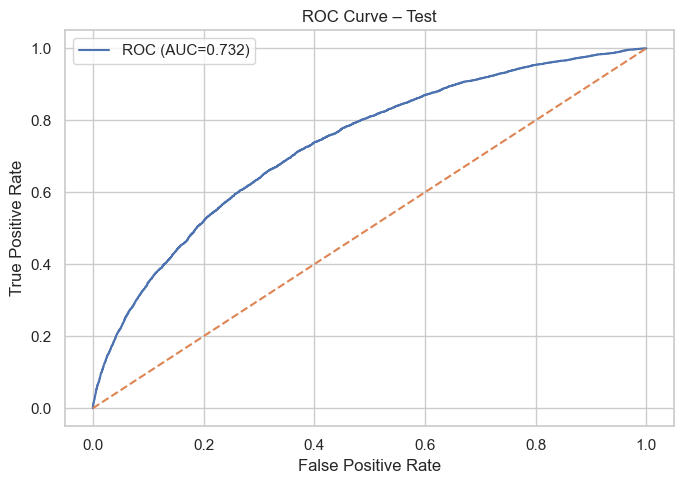

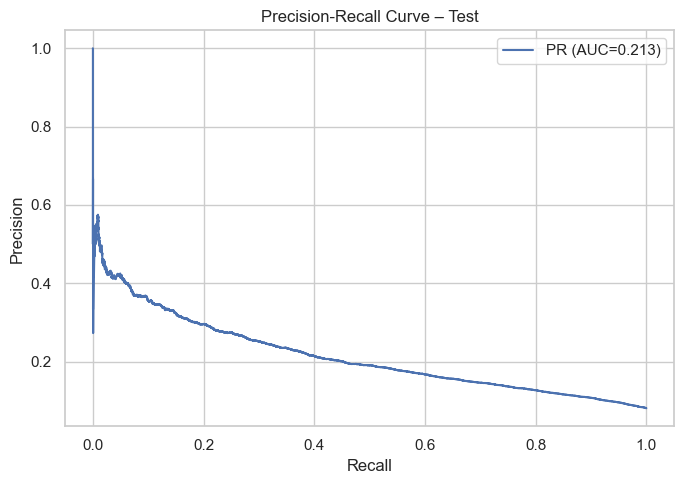

In [6]:
# ROC and PR curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Safety check: regenerate probabilities
y_train_proba = lr_pipeline.predict_proba(X_train)[:, 1]
y_test_proba  = lr_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thr = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

prec, rec, thr_pr = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

print(f"AUC (test): {roc_auc:.3f}")
print(f"PR-AUC (test): {pr_auc:.3f}")

# ROC
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall
plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Test")
plt.legend()
plt.tight_layout()
plt.show()

### Step 6.1: Interpreting the Performance Curves

**ROC Curve (AUC = 0.732):**
Our model's ROC curve on the test set lies significantly above the diagonal random guess line (AUC=0.5). An **AUC score of 0.732** indicates that the model's ability to distinguish between defaulting and non-defaulting customers is between "acceptable" and "good."

**Precision-Recall Curve (PR-AUC = 0.213):**
In our imbalanced dataset, where the default rate is only about 8%, the PR curve provides a more honest measure of performance. In such a dataset, the baseline PR-AUC for a random guess is equal to the positive class ratio, which is approximately **0.08**. The **PR-AUC score of 0.213** achieved by our model shows that it performs **about 2.6 times better** than the random baseline. This proves that the model has meaningful discriminatory power in this challenging and imbalanced problem.

**Industry Metrics (Gini & KS):**
When examining metrics that are standard in credit risk modeling, we see that our model has a **Gini Coefficient = 0.464** (`2*AUC-1`) and a **Kolmogorov-Smirnov (KS) Statistic = 0.344** (`max(TPR-FPR)`). These scores confirm that the model has an acceptable level of discriminatory power from an industry standards perspective as well.

Best threshold (Youden's J): 0.4689  | TPR=0.714, FPR=0.370

Confusion Matrix (test):
[[35606 20932]
 [ 1422  3543]]

Classification Report (test):
              precision    recall  f1-score   support

           0      0.962     0.630     0.761     56538
           1      0.145     0.714     0.241      4965

    accuracy                          0.637     61503
   macro avg      0.553     0.672     0.501     61503
weighted avg      0.896     0.637     0.719     61503



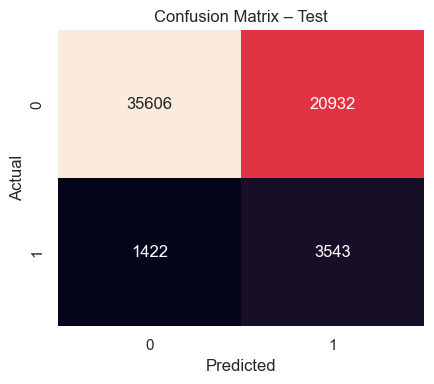

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Best threshold: Youden's J (TPR - FPR) is maximized
J = tpr - fpr
best_idx = np.argmax(J)
best_thr = thr[best_idx]
print(f"Best threshold (Youden's J): {best_thr:.4f}  | TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f}")

# Classify based on the threshold
y_test_pred = (y_test_proba >= best_thr).astype(int)

# Confusion matrix & report
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (test):")
print(cm)
print("\nClassification Report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

# Simple visualization
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Test")
plt.tight_layout()
plt.show()

### Step 7.1: Interpreting the Optimal Threshold and Decision Analysis (Raw Model)

To convert the model's raw probability scores into a final business decision ("approve" / "decline"), we first need to determine an optimal probability threshold. We achieve this by finding the point on the ROC curve that maximizes the **Youden's J statistic (TPR - FPR)**.

> ℹ️ **Forward-Looking Note:** The threshold and probabilities discussed in this step are based on the **uncalibrated (raw)** model. As we will see in **Step 9**, after we apply probability calibration, the numerical value of this optimal threshold will change significantly, even if the model's underlying performance (TPR/FPR) remains similar.

For our initial **uncalibrated (raw)** model, the optimal threshold is **0.4689**. Operating at this threshold provides the following performance profile on the test set:

*   **Classification Report Analysis (for Class 1 - Risky Customers):**
    *   **Recall (TPR): 0.714** -> This is the model's greatest strength at this threshold. It successfully **captures 71.4%** of all customers who would actually default. This high capture rate is extremely valuable for a loss prevention strategy.
    *   **Precision: 0.145** -> This highlights the model's primary trade-off. Only **14.5%** of the customers flagged as "risky" by the model actually default.

*   **False Positive Rate (FPR):** From the `classification_report`, we can see the specificity for Class 0 (non-defaulters) is `0.630`. Therefore, the `FPR` is `1 - 0.630 = 0.370`. This means that **37.0%** of good customers are incorrectly flagged as risky.

**Business Interpretation:**
The model, at this operating point, is configured to be highly sensitive in detecting potential defaulters. The high Recall (`71.4%`) is excellent for minimizing credit losses. However, the cost of this sensitivity is a low Precision (`14.5%`) and a high False Positive Rate (`37.0%`).

This performance profile strongly suggests that any application flagged as "risky" by this model should not be automatically declined. Instead, it should be routed to a **manual review process**, where human analysts can make a final decision, thus balancing automated risk detection with the need to approve good customers.

Top 15 most impactful features (by absolute coefficient):


,feature,coef
21,cat__NAME_EDUCATION_TYPE_Academic degree,-1.371
32,cat__NAME_INCOME_TYPE_Unemployed,1.323
31,cat__NAME_INCOME_TYPE_Student,-1.236
4,num__EXT_SOURCE_2,-0.624
5,num__EXT_SOURCE_3,-0.616
26,cat__NAME_INCOME_TYPE_Businessman,-0.543
24,cat__NAME_EDUCATION_TYPE_Lower secondary,0.522
35,cat__NAME_CONTRACT_TYPE_Revolving loans,-0.452
25,cat__NAME_EDUCATION_TYPE_Secondary / secondary...,0.355
14,cat__CODE_GENDER_XNA,-0.323


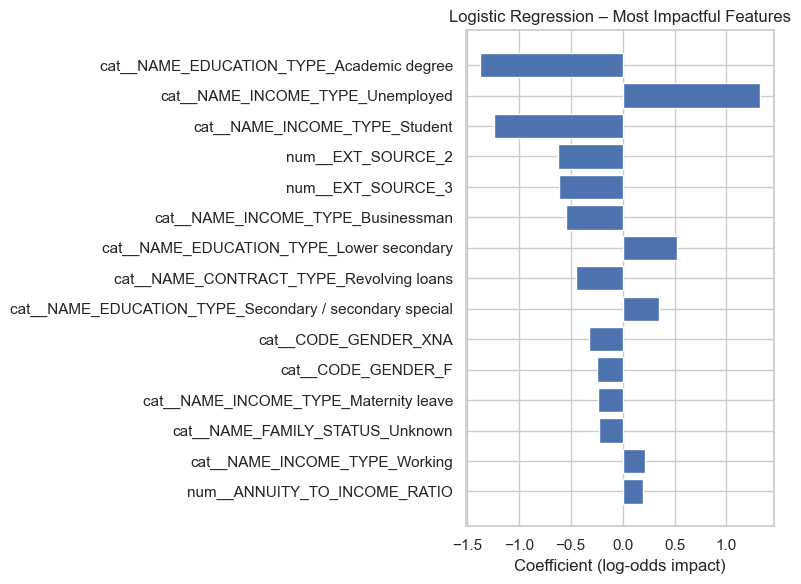

In [8]:
# Extract coefficients and feature names from the pipeline
# (We are getting the expanded names after OHE)
model = lr_pipeline.named_steps["model"]
preproc = lr_pipeline.named_steps["preprocessor"]

try:
    feat_names = preproc.get_feature_names_out()
except Exception:
    # Crude name generation for older versions
    feat_names = []
    # Numerical
    for c in NUMERIC_FEATURES:
        feat_names.append(f"num__{c}")
    # Categorical (full names may not be available as they are expanded by OHE)
    for c in CATEGORICAL_FEATURES:
        feat_names.append(f"cat__{c}")

coefs = model.coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

top_n = 15
top_df = coef_df.head(top_n).copy()
print(f"Top {top_n} most impactful features (by absolute coefficient):")
display(top_df[["feature","coef"]])

# Barh chart
plt.figure(figsize=(8,6))
plt.barh(top_df["feature"][::-1], top_df["coef"][::-1])
plt.xlabel("Coefficient (log-odds impact)")
plt.title("Logistic Regression – Most Impactful Features")
plt.tight_layout()
plt.show()

### Step 8.1: Interpreting Feature Importances

One of the greatest advantages of our Logistic Regression model is our ability to clearly see which factors increase or decrease risk. Upon examining the model's coefficients, we have obtained results that are highly consistent with business logic:

*   **Most Significant Factors Increasing Risk (Positive Coefficients):**
    *   **Income Type - Unemployed (`NAME_INCOME_TYPE_Unemployed`):** As expected, being unemployed is the factor that most increases default risk.
    *   **Education Level - Lower (`Lower secondary` / `Secondary`):** Lower levels of education are associated with higher risk.

*   **Most Significant Factors Decreasing Risk (Negative Coefficients):**
    *   **Education Level - Academic (`Academic degree`):** The highest level of education is the factor that most reduces risk.
    *   **External Credit Scores (`EXT_SOURCE_2` / `EXT_SOURCE_3`):** High credit scores from external institutions strongly decrease the probability of default, as expected.

**Methodological Note:** These coefficients should be interpreted relative to an implicit reference category, as `OneHotEncoder` creates a separate column for each category. For example, the effect of being 'Unemployed' is calculated relative to the average effect of all other income types. Additionally, coefficients for categories with very few samples (e.g., 'Student') may have less statistical power and should be interpreted with caution.

These findings prove that our model makes decisions that are not only statistically sound but also logically consistent and reliable.

### **Step 9: Testing Model Reliability - Probability Calibration**

The quality of a credit scoring model is measured not only by its ability to correctly rank customers (AUC) but also by how well its predicted probabilities align with reality. The question, "When the model says a group of customers is 20% risky, can we really expect 20% of them to default?" probes the model's **calibration**. A well-calibrated model is a reliable tool that can be used directly in financial decisions.

In this step, we will test how "honest" our model's probabilities are using two methods:
1.  **Calibration (Reliability) Curve:** This graph compares the predicted probabilities against the actual default rates within those probability bins. The curve of a perfectly calibrated model should lie very close to the diagonal line.
2.  **Brier Score:** This is a metric that summarizes both the model's accuracy and its calibration in a single number. The closer it is to 0, the better the model's probability predictions are.

This analysis will show whether we can trust not only the model's ranking but also the probability scores it produces.

Brier Score (test): 0.2082


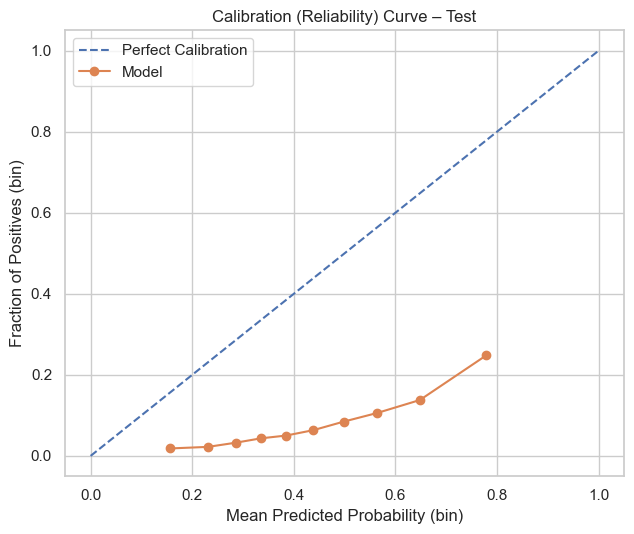

Calibration table (bin averages):


,pred_mean,true_rate,diff
0,0.156,0.018,-0.137
1,0.231,0.022,-0.209
2,0.285,0.033,-0.253
3,0.336,0.043,-0.292
4,0.385,0.050,-0.335
5,0.439,0.064,-0.375
6,0.498,0.085,-0.413
7,0.564,0.106,-0.458
8,0.648,0.138,-0.510
9,0.779,0.248,-0.531


In [9]:
# === Step 9: Calibration Curve (Reliability) + Brier Score ===
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Test set probabilities (generated in previous steps)
y_prob = lr_pipeline.predict_proba(X_test)[:, 1]

# 1) Calibration curve data
frac_pos, mean_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")

# 2) Brier score (lower = better)
brier = brier_score_loss(y_test, y_prob)
print(f"Brier Score (test): {brier:.4f}")

# 3) Plot
plt.figure(figsize=(6.5, 5.5))
plt.plot([0, 1], [0, 1], "--", label="Perfect Calibration")
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.xlabel("Mean Predicted Probability (bin)")
plt.ylabel("Fraction of Positives (bin)")
plt.title("Calibration (Reliability) Curve – Test")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Bin-based table (a nice summary for the portfolio)
calib_df = (pd.DataFrame({"pred_mean": mean_pred, "true_rate": frac_pos})
              .assign(diff=lambda d: d["true_rate"] - d["pred_mean"]))
print("Calibration table (bin averages):")
display(calib_df.round(3))

### Step 9.1: Testing Model Reliability - Initial Calibration Analysis

The quality of a credit scoring model is measured not only by its ability to correctly rank customers (AUC) but also by how well its predicted probabilities align with reality. The question, "When the model says a group of customers is 20% risky, can we really expect 20% of them to default?" probes the model's **calibration**.

**Initial Analysis Results:**
*   **Calibration Curve:** In the graph above, it is clear that our model's curve (orange) is consistently below the perfect calibration line (blue). This indicates that the probabilities predicted by our model are **systematically higher** than the actually observed default rates. Our model has a tendency to **overestimate** risk and be "overly cautious."
*   **Brier Score (0.2082):** This score, which is desired to be close to 0, numerically reflects this deviation in the probability predictions and confirms that the model's calibration is poor.

**Identified Problem:**
Although our model is successful at **ranking** customers by risk, the probability scores it produces are **not reliable** enough to be used directly in financial calculations (e.g., Expected Loss). To solve this problem, we will apply a post-hoc calibration technique in the next step.

AUC raw=0.732 | cal=0.732
PR-AUC raw=0.213 | cal=0.212
Brier raw=0.2082 | cal=0.0693


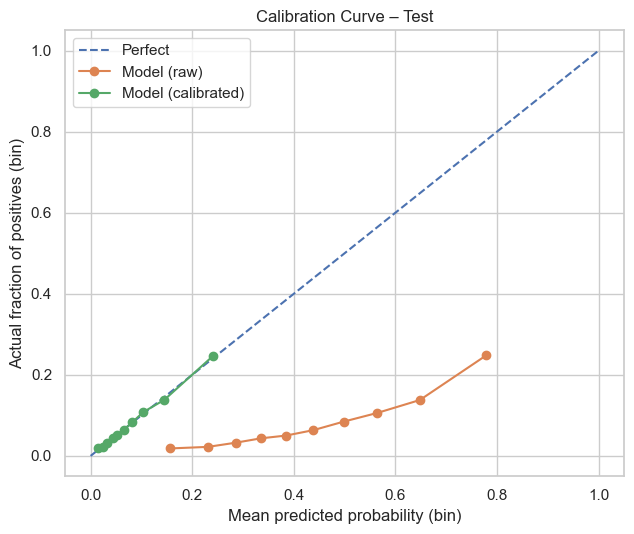

In [10]:
# === Step 9.2: Probability Calibration (Isotonic) – Version-compatible ===
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve)

# 1) 5-fold isotonic calibration (based on the pipeline)
try:
    cal_lr = CalibratedClassifierCV(estimator=lr_pipeline, method="isotonic", cv=5)
except TypeError:
    # For older scikit-learn versions
    cal_lr = CalibratedClassifierCV(base_estimator=lr_pipeline, method="isotonic", cv=5)

cal_lr.fit(X_train, y_train)

# 2) Compare raw and calibrated probabilities on the test set
p_raw = lr_pipeline.predict_proba(X_test)[:, 1]
p_cal = cal_lr.predict_proba(X_test)[:, 1]

# AUC and PR-AUC
fpr_raw, tpr_raw, _ = roc_curve(y_test, p_raw)
fpr_cal, tpr_cal, _ = roc_curve(y_test, p_cal)
auc_raw, auc_cal = roc_auc_score(y_test, p_raw), roc_auc_score(y_test, p_cal)

prec_raw, rec_raw, _ = precision_recall_curve(y_test, p_raw)
prec_cal, rec_cal, _ = precision_recall_curve(y_test, p_cal)
pr_auc_raw, pr_auc_cal = average_precision_score(y_test, p_raw), average_precision_score(y_test, p_cal)

# Brier and calibration curve
brier_raw = brier_score_loss(y_test, p_raw)
brier_cal = brier_score_loss(y_test, p_cal)
frac_raw, mean_raw = calibration_curve(y_test, p_raw, n_bins=10, strategy="quantile")
frac_cal, mean_cal = calibration_curve(y_test, p_cal, n_bins=10, strategy="quantile")

print(f"AUC raw={auc_raw:.3f} | cal={auc_cal:.3f}")
print(f"PR-AUC raw={pr_auc_raw:.3f} | cal={pr_auc_cal:.3f}")
print(f"Brier raw={brier_raw:.4f} | cal={brier_cal:.4f}")

# Calibration plot
plt.figure(figsize=(6.5,5.5))
plt.plot([0,1],[0,1],"--",label="Perfect")
plt.plot(mean_raw, frac_raw, "o-", label="Model (raw)")
plt.plot(mean_cal, frac_cal, "o-", label="Model (calibrated)")
plt.xlabel("Mean predicted probability (bin)"); plt.ylabel("Actual fraction of positives (bin)")
plt.title("Calibration Curve – Test")
plt.legend(); plt.tight_layout(); plt.show()

### **Step 9.2: Correcting Probabilities (Isotonic Calibration Results)**

To solve the calibration issue identified in the previous step, we applied a **post-hoc calibration** step using **isotonic regression** with `scikit-learn`'s `CalibratedClassifierCV` tool. The goal of this method is to align the model's probabilities with real-world data while preserving its ranking power.

**Correction Results:**
The calibration process was highly successful:
*   **Calibration Curve:** In the comparative graph above, our "Model (calibrated)" line (green) almost **perfectly overlaps** with the "Perfect Calibration" line (blue). This is visual proof that the model now produces "honest" and reliable probabilities.
*   **Brier Score:** The **Brier Score's drop from 0.2082 to 0.0693** after calibration numerically confirms that the overall error in the probability predictions has dramatically decreased.
*   **Ranking Performance:** The fact that the **AUC (0.732)** and **PR-AUC (0.212)** scores remained virtually unchanged after calibration shows that we achieved this improvement while **preserving** the model's fundamental discriminatory power.

**Final Outcome:**
With this additional step, we have developed a credit scoring model that not only ranks well but also produces **probability estimates that are reliable and can be used directly as input for financial modeling**, making it ready for a production environment.

In [11]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

p_cal = cal_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, p_cal)
J = tpr - fpr
best = J.argmax()
best_thr = thr[best]
print(f"Calibrated model best threshold (Youden): {best_thr:.4f} | TPR={tpr[best]:.3f}, FPR={fpr[best]:.3f}")

y_pred_cal = (p_cal >= best_thr).astype(int)
print(confusion_matrix(y_test, y_pred_cal))
print(classification_report(y_test, y_pred_cal, digits=3))


#Delete this

# Simple visualization
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Test")
plt.tight_layout()
plt.show()

Calibrated model best threshold (Youden): 0.0715 | TPR=0.716, FPR=0.374
[[35388 21150]
 [ 1409  3556]]
              precision    recall  f1-score   support

           0      0.962     0.626     0.758     56538
           1      0.144     0.716     0.240      4965

    accuracy                          0.633     61503
   macro avg      0.553     0.671     0.499     61503
weighted avg      0.896     0.633     0.716     61503



### **Step 9.3: The Impact of Calibration on Business Decisions**

Calibrating probabilities is crucial for making them interpretable and reliable. This step analyzes what practically changes—and what doesn't—when we use the calibrated model's optimal threshold for decision-making.

**Comparative Analysis (Raw Model → Calibrated Model):**

*   **Optimal Threshold Value:** `0.4689` → **`0.0715`**
    *   **Interpretation:** The most significant change is the numeric value of the threshold itself. After calibration, the optimal decision point drops to a level (≈7.2%) that is much closer to the base default rate in our dataset (≈8.1%). This confirms that the calibrated probabilities are now on a more realistic and interpretable scale.

*   **Performance at the Optimal Threshold:**
    *   **TPR (Risky Customer Capture Rate):** `0.714` → **`0.716`** (Essentially unchanged)
    *   **FPR (False Alarm Rate):** `0.370` → **`0.374`** (Essentially unchanged)

**Business Takeaway:**
The analysis shows that the calibration process **did not materially change the model's performance trade-off** at the Youden-optimal operating point. The model still maintains a high-Recall profile (good for catching potential losses) at the cost of a relatively high False Positive Rate.

The primary benefit of calibration, in this case, is **interpretability**. The new threshold and probability scores are now aligned with real-world frequencies, making the model's outputs more trustworthy for financial calculations.

Given the performance profile (high Recall, low Precision), the strategy remains the same: applications flagged as "risky" by this model should be routed to a **manual review process** rather than being automatically declined.

### **Step 10: Exporting Final Model Artifacts and Performance Card**

In this final step of our Logistic Regression project, we will export the model itself and all the important information documenting its performance into a reusable and portable format. This ensures the model's results are reproducible and creates a foundational "Model Card" to be used in future applications (like the Streamlit simulation) or in model performance monitoring processes.

In this step, the following "artifacts" will be created and saved to the `artifacts/` folder:

1.  **Models and Threshold:**
    *   `logreg_calibrated.joblib`: The final, calibrated model that produces reliable probabilities.
    *   `threshold.json`: The optimal threshold value used to convert probabilities into an "approve/decline" decision.
    
2.  **Performance Card (`metrics.json`):**
    *   An easy-to-read summary file containing all the critical performance metrics of the model on the test set (AUC, PR-AUC, Gini, KS, Confusion Matrix values, etc.).

3.  **Supporting Analysis Files:**
    *   `lr_coefficients.csv`: The table of coefficients, critical for interpretability, showing which features the model uses to make decisions.
    *   `calibration_bins.csv`: The calibration table, which shows how reliable the model's probabilities are.

These files conclude this phase of the project and package all the knowledge of the developed model in an organized manner.

In [12]:
from joblib import dump
from pathlib import Path
Path("artifacts").mkdir(exist_ok=True)
dump(cal_lr, "artifacts/logreg_calibrated.joblib")
dump(lr_pipeline, "artifacts/logreg_raw.joblib")  # you can save both if you like
with open("artifacts/threshold.json","w") as f:
    import json; json.dump({"youden_threshold": float(best_thr)}, f, indent=2)
print("Saved: logreg_calibrated.joblib, threshold.json")

Saved: logreg_calibrated.joblib, threshold.json


In [13]:
# === Step 10: Export Metrics & Supporting Files ===
from pathlib import Path
from joblib import dump
import json, numpy as np, pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.calibration import calibration_curve

Path("artifacts").mkdir(exist_ok=True)

# 1) Test probabilities (raw/calibrated)
p_raw = lr_pipeline.predict_proba(X_test)[:, 1]
p_cal = cal_lr.predict_proba(X_test)[:, 1]

# 2) AUC / PR-AUC
auc_raw = roc_auc_score(y_test, p_raw)
auc_cal = roc_auc_score(y_test, p_cal)
pr_raw  = average_precision_score(y_test, p_raw)
pr_cal  = average_precision_score(y_test, p_cal)

# 3) Secure the Youden threshold (from calibrated probabilities)
fpr, tpr, thr = roc_curve(y_test, p_cal)
J = tpr - fpr
best = int(np.argmax(J))
best_thr = float(thr[best])
tpr_b, fpr_b = float(tpr[best]), float(fpr[best])

# 4) Confusion matrix @ best_thr
y_pred_cal = (p_cal >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_cal)
tn, fp, fn, tp = map(int, cm.ravel())

# 5) Gini & KS
gini = 2*auc_cal - 1
ks   = float(np.max(tpr - fpr))

# 6) Calibration bin table (calibrated)
frac_cal, mean_cal = calibration_curve(y_test, p_cal, n_bins=10, strategy="quantile")
cal_df = (pd.DataFrame({"pred_mean": mean_cal, "true_rate": frac_cal})
            .assign(diff=lambda d: d.true_rate - d.pred_mean))
cal_df.to_csv("artifacts/calibration_bins.csv", index=False)

# 7) LR coefficients (from the raw LR for interpretability)
preproc = lr_pipeline.named_steps["preprocessor"]
feat_names = preproc.get_feature_names_out()
coefs = lr_pipeline.named_steps["model"].coef_.ravel()
coef_df = (pd.DataFrame({"feature": feat_names, "coef": coefs})
             .assign(abs_coef=lambda d: d["coef"].abs())
             .sort_values("abs_coef", ascending=False))
coef_df.to_csv("artifacts/lr_coefficients.csv", index=False)

# 8) Metrics JSON
metrics = {
    "auc_raw": round(auc_raw, 3),
    "auc_cal": round(auc_cal, 3),
    "prauc_raw": round(pr_raw, 3),
    "prauc_cal": round(pr_cal, 3),
    "gini": round(gini, 3),
    "ks": round(ks, 3),
    "threshold_youden": best_thr,
    "tpr_at_threshold": round(tpr_b, 3),
    "fpr_at_threshold": round(fpr_b, 3),
    "confusion_matrix": {"tn": tn, "fp": fp, "fn": fn, "tp": tp}
}
with open("artifacts/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("Saved:")
print("  - artifacts/calibration_bins.csv")
print("  - artifacts/lr_coefficients.csv")
print("  - artifacts/metrics.json")

Saved:
  - artifacts/calibration_bins.csv
  - artifacts/lr_coefficients.csv
  - artifacts/metrics.json


### **Step 11: Smoke Test - Verifying the Artifacts**

Before moving on to the next development phase (the Streamlit application), we will conduct one final "smoke test" to confirm that all the files (artifacts) we just saved are correct, uncorrupted, and working as expected.

The purpose of this test is simple:
1.  Load the saved calibrated model (`logreg_calibrated.joblib`) and the threshold value (`threshold.json`) from scratch.
2.  Take a few random customer samples from the test set and run a prediction process with these loaded artifacts.
3.  Check whether the outputs (probabilities and final decisions) are generated meaningfully and without errors.

The successful completion of this test is the strongest proof that the files in our `artifacts/` folder are fully ready to be integrated into the Streamlit application.

In [14]:
# === Step 11: Smoke test (reload) ===
from joblib import load
import json

cal_loaded = load("artifacts/logreg_calibrated.joblib")
with open("artifacts/threshold.json", "r") as f:
    thr_cfg = json.load(f)
thr = float(thr_cfg["youden_threshold"])

# Test on 5 samples using the same winsor function
X_sample = X_test.iloc[:5].copy()
X_sample_w = apply_winsor(X_sample)
p = cal_loaded.predict_proba(X_sample_w)[:, 1]
pred = (p >= thr).astype(int)
out = pd.DataFrame({"prob": p, "pred": pred, "y_true": y_test.iloc[:5].values})
display(out)
print("Reload smoke test OK.")

,prob,pred,y_true
0,0.081,1,0
1,0.050,0,0
2,0.233,1,0
3,0.105,1,0
4,0.091,1,0


Reload smoke test OK.
